In [15]:
import os
import sys
import pdb
import copy
import glob
import warnings
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.util as cutil
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
from matplotlib import colors
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
import matplotlib.transforms as mtransforms
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append(os.path.abspath("/global/homes/j/jhollo/repos/climate_util"))
from PyTEMDiags import sph_zonal_averager
import climate_toolbox as ctb
import artist_utils as au

# ---------- matplotlib settings

mpl.rcParams.update(mpl.rcParamsDefault)

SMALL_SIZE  = 9
MEDIUM_SIZE = 11
BIG_SIZE    = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

print('done')

done


In [16]:
# ==================================
# ========= read data ==============

data_dest = '/pscratch/sd/j/jhollo/tmp'

print('reading mean climate...')
mean_clim = '/pscratch/sd/j/jhollo/E3SM/E3SMv2_cases/sai_cases/ic_ens/HSW_SAI_ne16pg2_L72_3600day_mc/run/HSW_SAI_ne16pg2_L72_3600day_mc.eam.h0.0001-01-01-00000.nc'
mean_clim = xr.open_dataset(mean_clim)
mean_clim = mean_clim.assign_coords(time = ctb.time2day(mean_clim['time']))
mean_clim = mean_clim.sel(time = slice(0, 3600)).mean('time')

print('reading ensemble...')
ens_members = sorted(glob.glob('/global/cfs/cdirs/m4014/data/HSW/outputs/release_011423/netcdf/ens_members/ens*/*h2*.nc'))
ens_members = [xr.open_dataset(mem) for mem in ens_members]
ens_members = [mem.assign_coords(time = ctb.time2day(mem['time'])) for mem in ens_members]

datlat = ens_members[0]['lat']
lat    = np.linspace(-90, 90, 181)
lev    = ens_members[0]['lev']
time   = ens_members[0]['time']
TIME, LEV = np.meshgrid(time, lev)
weights = xr.DataArray(np.cos(np.deg2rad(lat)), coords={'lat':lat})

print('getting total tracer masses...')
sulf_q        = [mem['SULFATE'] for mem in ens_members]
sulf_colmass  = [(mem['SULFATE'] * mem['AIR_MASS']) * 1e-9 for mem in ens_members]
sulf_mass     = sulf_colmass[0].sum(dim=('ncol', 'lev'))
SO2_mass      = (ens_members[0]['SO2'] * ens_members[0]['AIR_MASS']).sum(dim=('ncol', 'lev')) * 1e-9

print('taking T zonal means...')
T_mc   = mean_clim['T']
T_mems = [mem['T'] for mem in ens_members]
zm     = sph_zonal_averager(datlat, lat, L=70, debug=False)
zm.sph_compute_matrices()
T_mc   = zm.sph_zonal_mean(T_mc.T).T
T_mems = [zm.sph_zonal_mean(T_mem.T).T for T_mem in T_mems]

print('taking T meridional means...')
T_mc    = T_mc.weighted(weights)
T_mc    = T_mc.mean('lat')
T_mems  = [T_mem.weighted(weights) for T_mem in T_mems]
T_mems  = [T_mem.mean('lat') for T_mem in T_mems]

print('getting ensemble mean T...')
T_em = xr.zeros_like(T_mems[0])
for i in range(len(T_mems)):
    T_em = T_em + T_mems[i]
T_em = T_em / len(T_mems)

print('getting ensemble std T...')
T_es = xr.zeros_like(T_em)
for i in range(len(T_mems)):
    T_es = T_es + (T_mems[i] - T_em)**2
T_es = np.sqrt(T_es / len(T_mems))

print('getting T anomaly...')
T_anom = T_em - T_mc

print('done')

reading mean climate...
reading ensemble...
getting total tracer masses...
taking T zonal means...
taking T meridional means...
getting ensemble mean T...
getting ensemble std T...
getting T anomaly...
done


In [17]:
COM_latrange = slice(-5, 35)

print('getting Z3...')
z_mems    = [mem['Z3']/1000 for mem in ens_members]

print('taking SULF zonal means...')
sulf_mems    = [zm.sph_zonal_mean(sulf_mem.T).T for sulf_mem in sulf_colmass]
sulf_zm_mems = copy.deepcopy(sulf_mems)
sulf_q_mems  = [zm.sph_zonal_mean(q_mem.T).T for q_mem in sulf_q]
print('taking Z3 zonal means...')
z_mems    = [zm.sph_zonal_mean(z_mem.T).T for z_mem in z_mems]

print('getting lat subset of SULF for COM...')
sulf_mems   = [sulf_mem.sel(lat=COM_latrange) for sulf_mem in sulf_mems]
sulf_q_mems = [q_mem.sel(lat=COM_latrange) for q_mem in sulf_q_mems]
print('getting lat subset of Z3 for COM...')
z_mems    = [z_mem.sel(lat=COM_latrange) for z_mem in z_mems]
weights   = weights.sel(lat=COM_latrange)

print('taking SULF meridional means...')
sulf_mems   = [sulf_mem.weighted(weights) for sulf_mem in sulf_mems]
sulf_mems   = [sulf_mem.mean('lat') for sulf_mem in sulf_mems]
sulf_q_mems = [q_mem.weighted(weights) for q_mem in sulf_q_mems]
sulf_q_mems = [q_mem.mean('lat') for q_mem in sulf_q_mems]
print('taking Z3 meridional means...')
z_mems    = [z_mem.weighted(weights) for z_mem in z_mems]
z_mems    = [z_mem.mean('lat') for z_mem in z_mems]

print('getting ensemble mean SULF...')
sulf_em = xr.zeros_like(sulf_mems[0])
for i in range(len(sulf_mems)):
    sulf_em = sulf_em + sulf_mems[i]
sulf_em = sulf_em / len(sulf_mems)
print('getting ensemble mean SULF zonalmean...')
sulf_zm_em = xr.zeros_like(sulf_zm_mems[0])
for i in range(len(sulf_zm_mems)):
    sulf_zm_em = sulf_zm_em + sulf_zm_mems[i]
sulf_zm_em = sulf_zm_em / len(sulf_zm_mems)
print('getting ensemble mean SULF q...')
sulf_q_em = xr.zeros_like(sulf_q_mems[0])
for i in range(len(sulf_q_mems)):
    sulf_q_em = sulf_q_em + sulf_q_mems[i]
sulf_q_em = sulf_q_em / len(sulf_q_mems)
print('getting ensemble mean Z3...')
z_em = xr.zeros_like(z_mems[0])
for i in range(len(z_mems)):
    z_em = z_em + z_mems[i]
z_em = z_em / len(z_mems)

print('done')

getting Z3...
taking SULF zonal means...
taking Z3 zonal means...
getting lat subset of SULF for COM...
getting lat subset of Z3 for COM...
taking SULF meridional means...
taking Z3 meridional means...
getting ensemble mean SULF...
getting ensemble mean SULF zonalmean...
getting ensemble mean SULF q...
getting ensemble mean Z3...
done


In [18]:
print('getting eruption position...')
erupt_pos = np.interp([14], z_em.mean('time')[::-1], lev[::-1])[0]
erupt_time = 180

COM_levrange = slice(0.1, erupt_pos)

print('getting vertical center of mass...')
num_em  = (sulf_em * z_em).sel(lev=COM_levrange).sum(dim='lev')
den_em  = (sulf_em).sel(lev=COM_levrange).sum(dim='lev')
COM_em  = num_em / den_em

print('interpolating COM to pressure...')
COMp_em = np.interp(COM_em, z_em.mean('time')[::-1], lev[::-1])

print('getting vertical position of peak mass...')
sulf_argmax = sulf_em.argmax(dim='lev')
PM_em = lev[sulf_argmax].values
PM_em[sulf_argmax == 0] = float('NaN')
sulf_q_argmax = sulf_q_em.argmax(dim='lev')
PM_q_em = lev[sulf_q_argmax].values
PM_q_em[sulf_q_argmax == 0] = float('NaN')

print('done')

getting eruption position...
getting vertical center of mass...
interpolating COM to pressure...
getting vertical position of peak mass...
done


plotting global temperature anomaly...
plotting global temperature anomaly at levels...
plotting tracer masses...


/tmp/ipykernel_382765/214801348.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


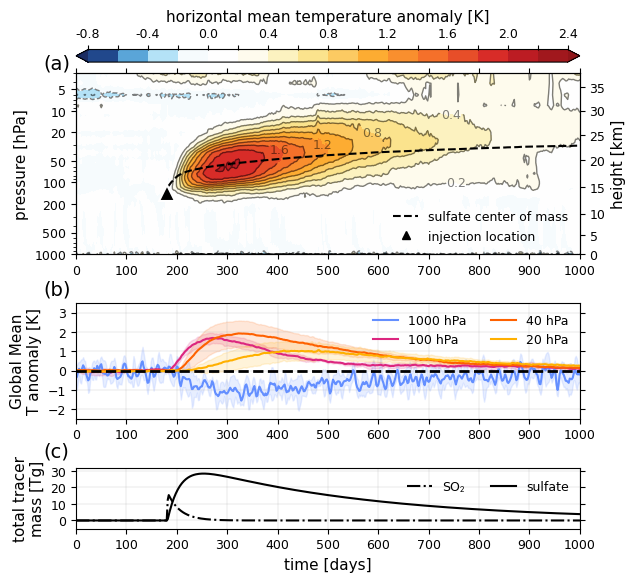

In [19]:
# =============================================
# ===============  plotting  ==================

Tstep         = 0.2
Tlevels       = np.hstack([-(np.arange(Tstep, 1, Tstep)[::-1]), np.arange(0, 2.5, Tstep)])
Tclevels      = Tlevels[~np.isclose(Tlevels, 0)]
Tlevels_norm  = colors.TwoSlopeNorm(vmin=min(Tlevels), vcenter=0., vmax=max(Tlevels))

#Tcmap = 'RdYlBu_r'
#Tcmap = au.ncl_rgb_to_cmap('/global/homes/j/jhollo/repos/climate_util/ncl_cmaps/BlueWhiteOrangeRed.rgb')
Tcmap = au.BlueWhiteOrangeRed
Tlw           = 1
Tccolor       = 'k'
Tcalpha       = 0.5

levlim        = [3, 1000]
timelim       = [0, 1000]
timeticks     = np.arange(min(timelim), max(timelim)+100, 100)
levticks      = [1000, 500, 200, 100, 50, 20, 10, 5]

Tlev_zorder = [4, 3, 2, 1]
Tlev        = [20, 40, 100, 1000][::-1]
Tlevcolor   = ['#648FFF', '#DC267F', '#FE6100', '#FFB000']
#Tlev        = [25, 100, 1000][::-1]
#Tlevcolor   = ['#648FFF', '#DC267F', '#FE6100']
Tlevalpha   = 0.15

SO2_color     = 'k'
sulf_color    = 'k'
gridlw        = 0.3
gridalpha     = 0.66

TIME, LEV = np.meshgrid(time, lev)

fig   = plt.figure(figsize=(6.5, 6.5))
gs    = fig.add_gridspec(nrows=10, ncols=1, hspace=8) 

# ---------- global T diff plot ----------
print('plotting global temperature anomaly...')

ax1 = fig.add_subplot(gs[0:5])
cf = ax1.contourf(TIME, LEV, T_anom.T, cmap=Tcmap, levels=Tlevels, extend='both', norm=Tlevels_norm)
ax1.plot(time, COMp_em, '--k', label='sulfate center of mass')
#ax1.plot(time, PM_em, ':k')
#ax1.plot(time, PM_q_em, '--b')
ax1.plot(erupt_time, erupt_pos, '^k', ms=12, mew=1.5, mec='w')
ax1.plot(-erupt_time, erupt_pos, '^k', ms=6, label='injection location') # dummy

cbar = fig.colorbar(cf, ax=ax1, orientation='horizontal', location='top', extendfrac=0.025,
                      aspect=40, extend='both', extendrect=False)#, format=Tlevels_fmt)

Tclevels = []
cbarlabels  = list(Tlevels)
for i in range(len(cbarlabels)):
    l = Tlevels[i]
    if(np.isclose((l*10)%4, 0)): 
        cbarlabels[i] = str(np.around(l, decimals=1))
        Tclevels.append(l)
    else: 
        cbarlabels[i] = ' '
        Tclevels.append(l)
cbar.ax.set_xticks(Tlevels, labels=cbarlabels)
Tclevels = np.array(Tclevels)[~np.isclose(Tclevels, 0)]

cfl = ax1.contour(TIME, LEV, T_anom.T, levels=Tclevels, colors=Tccolor, linewidths=Tlw, alpha=Tcalpha)
labs = ax1.clabel(cfl, inline=True, fontsize=SMALL_SIZE, inline_spacing=-2,
                  manual=[[754, 99], [745, 13], [587, 21], [490, 35], [404, 39]])
for lab in labs:
        lab.set_rotation(0)

#for l in Tclevels:
    #cbar.ax.axvline(l, color=Tccolor, lw=Tlw, alpha=Tcalpha)
cbar.set_label('horizontal mean temperature anomaly [K]')

ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y,pos: \
                             ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax1.set_ylabel('pressure [hPa]')
ax1.legend(loc='lower right', ncol=1, fancybox=False, shadow=False, frameon=False)
ax1.set_yticks(levticks)
ax1.set_ylim(levlim)
ax1.invert_yaxis()

ax1.set_xlim(timelim)
ax1.set_xticks(timeticks)
ax1.tick_params(top=True, bottom=True, labeltop=False, labelbottom=True, which='both')

ax1z = ax1.twinx()
ax1z.set_yscale('log')
zyticks_z = np.arange(0, 61, 5)
zyticks_p = np.interp(zyticks_z, z_em.mean('time')[::-1], lev[::-1])
ax1z.set_yticks(zyticks_p, labels=zyticks_z)
ax1z.set_ylim(levlim)
ax1z.invert_yaxis()
ax1z.tick_params(right=False, which='minor')
ax1z.set_ylabel('height [km]')

# ---------- global T diff plot at levels ----------
print('plotting global temperature anomaly at levels...')

ax2 = fig.add_subplot(gs[5:8])

for i in range(len(Tlev)):
    y    = T_anom.sel({'lev':Tlev[i]}, method='nearest')
    yerr = T_es.sel({'lev':Tlev[i]}, method='nearest')
    ax2.plot(time, y, label='{} hPa'.format(Tlev[i]), color=Tlevcolor[i])
    ax2.fill_between(time, y-yerr, y+yerr, color=Tlevcolor[i], alpha=Tlevalpha)
    
ax2.set_ylabel('Global Mean\nT anomaly [K]')
ax2.axhline(0, linestyle='--', color='k', lw=2)
ax2.grid(lw=gridlw, alpha=gridalpha)
leg = ax2.legend(loc='upper right', ncol=2, fancybox=False, shadow=False, frameon=False)

ax2.set_xlim(timelim)
ax2.set_xticks(timeticks)
ax2.set_ylim([-2.5, 3.5])
ax2.set_yticks([-2, -1, 0, 1, 2, 3])

ax2.tick_params(left=True, right=True, labelleft=True, labelright=False, which='both')


# ---------- total tracer masses ----------
print('plotting tracer masses...')

ax3 = fig.add_subplot(gs[8:])
ax3.plot(time, SO2_mass, linestyle='-.', color=SO2_color,  label='SO$_2$')
ax3.plot(time, sulf_mass, color=sulf_color, label='sulfate')

ax3.set_ylabel('total tracer\nmass [Tg]')
ax3.set_xlabel('time [days]')
ax3.legend(loc='upper right', ncol=2, fancybox=False, shadow=False, frameon=False)
ax3.grid(lw=gridlw, alpha=gridalpha)

ax3.set_xlim(timelim)
ax3.set_ylim([-5, 32])
ax3.set_yticks([0, 10, 20, 30])
ax3.set_xticks(timeticks)

ax3.tick_params(left=True, right=True, labelleft=True, labelright=False, which='both')

# ------------------------------------------

axs = [ax1, ax2, ax3]
axlabs = ['(a)', '(b)', '(c)']
for i in range(len(axs)):
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    pos = [-0.01, 0.95]
    axs[i].text(pos[0], pos[1], axlabs[i], transform=axs[i].transAxes + trans,
               fontsize=BIGGER_SIZE, va='bottom', fontfamily='sans-serif')

plt.tight_layout()
fig.savefig('figs/Tanom.pdf', dpi=300, bbox_inches='tight')
plt.show()

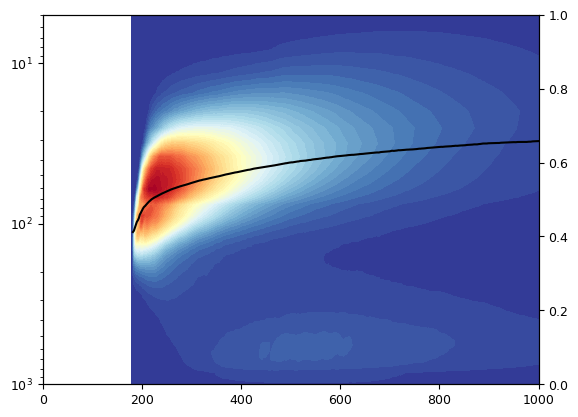

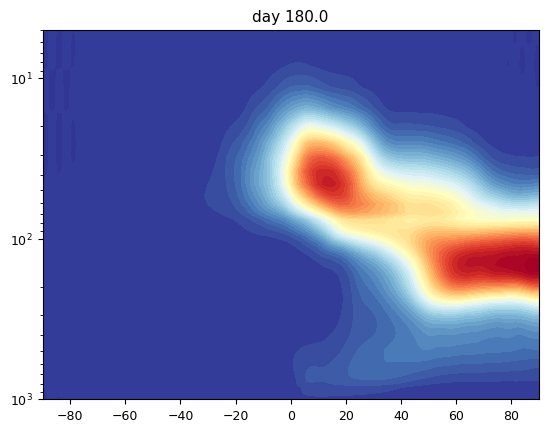

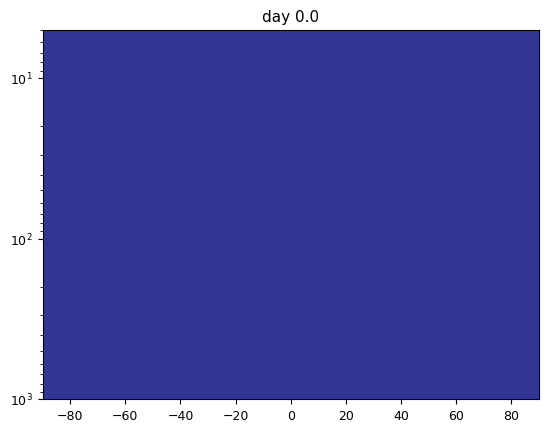

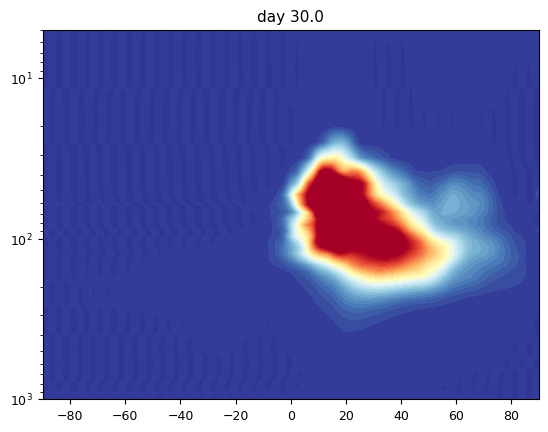

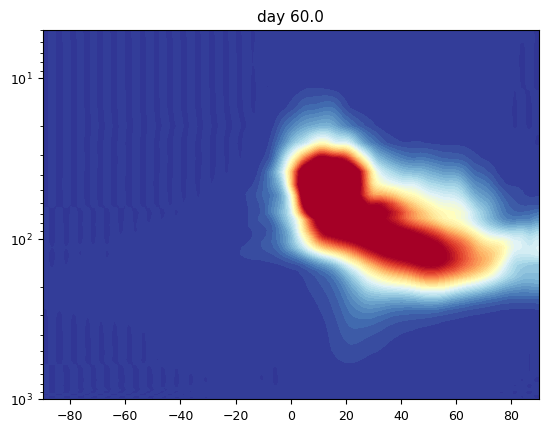

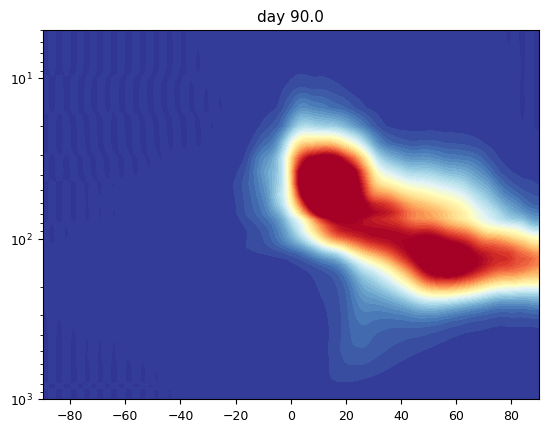

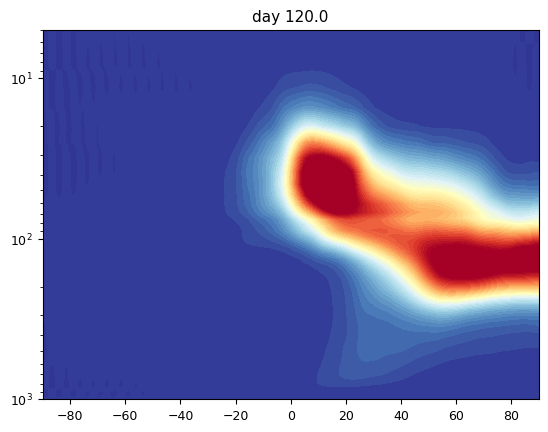

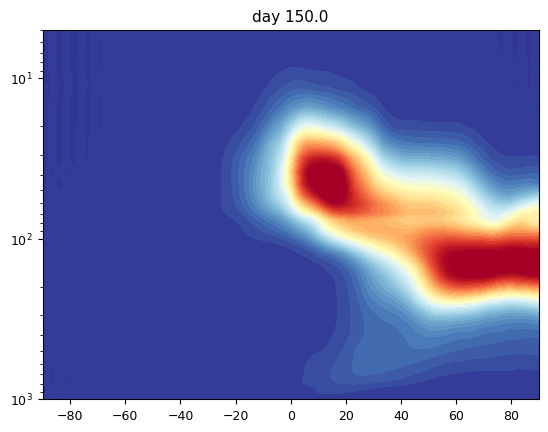

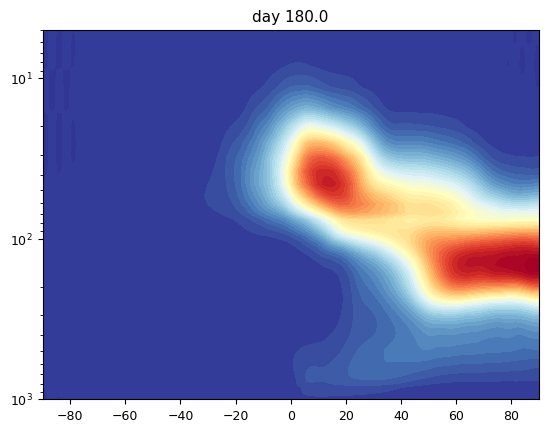

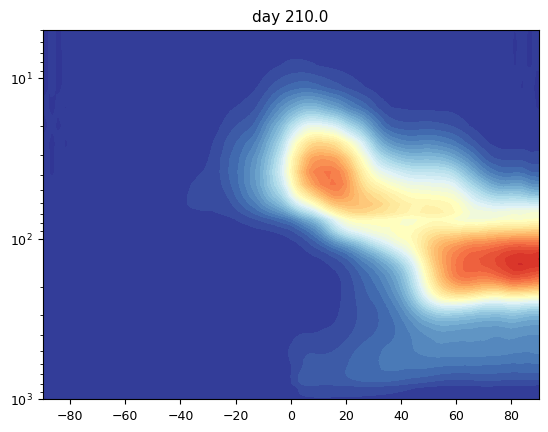

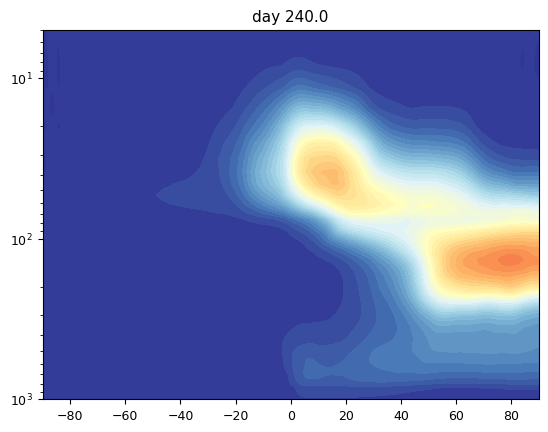

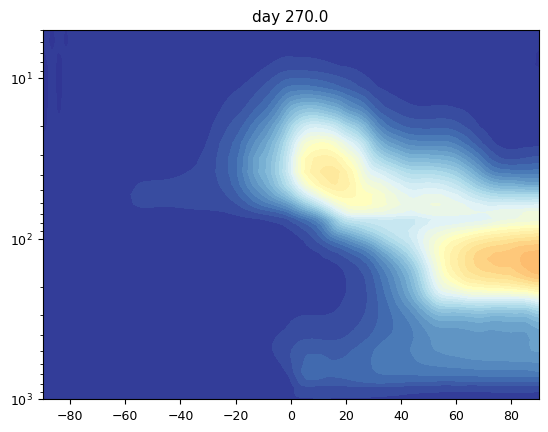

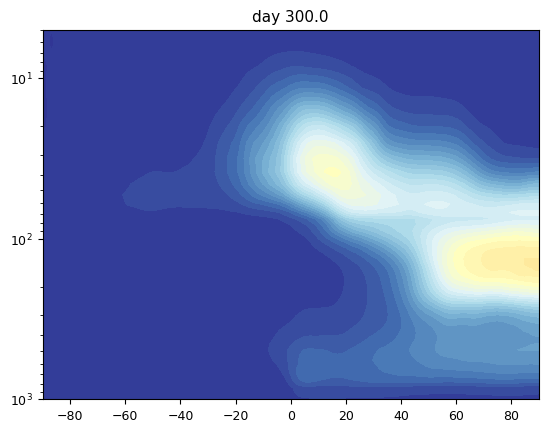

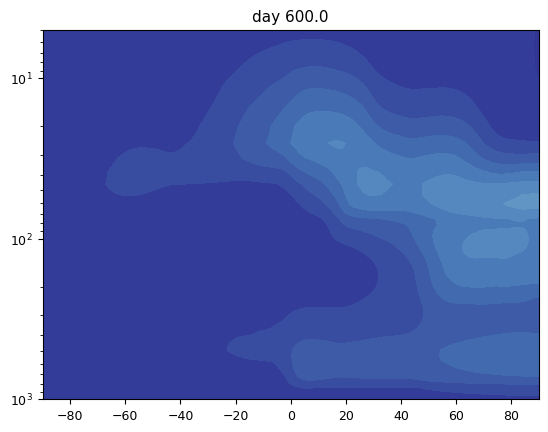

In [ ]:

# ==================================================
# ============= EXTRA DEBUGGING FIGURES ============


TIME, LEV = np.meshgrid(time, lev)
plt.contourf(TIME, LEV, sulf_em.T, levels=50, cmap='RdYlBu_r')
#plt.contour(TIME, LEV, sulf_em.T * z_em.T, colors='w', levels=10)
plt.plot(time, COMp_em, '-k')
plt.gca().set_xlim([0, 1000])
plt.gca().set_ylim([5, 1000])
plt.gca().invert_yaxis()
plt.gca().set_yscale('log')

ax2 = plt.gca().twinx()
#ax2.plot(time, sulf_em.sum('lev'), '-w')
#ax2.plot(time, (sulf_em.T * z_em.T).sum('lev'), '-r')

plt.show()

plottimes = np.array([6, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30])*30/2
cf = [0]*len(plottimes)
LAT, LEV = np.meshgrid(lat, lev)
for i in range(len(plottimes)):
    if(i == 0): levels=50
    else: levels = cf[0].levels
    cf[i] = plt.contourf(LAT, LEV, sulf_zm_em.isel(time = int(180/2 + plottimes[i])), levels=levels, cmap='RdYlBu_r', extend='both')
    plt.title('day {}'.format(plottimes[i] * 2))
    plt.gca().set_ylim([5, 1000])
    plt.gca().invert_yaxis()
    plt.gca().set_yscale('log')
    plt.show()